In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir='/content/drive/MyDrive/Computer vission/Dataset/Attendance_dataset'

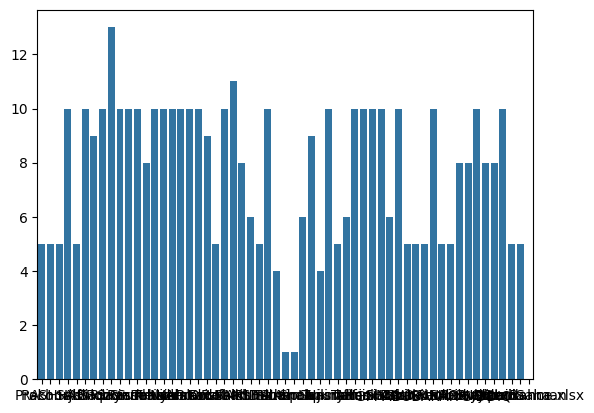

In [4]:
IMG_SIZE=128
BATCH_SIZE=16
categories = []
class_count = []

train_example = 0
for f in os.listdir(data_dir):
    files = gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][eE][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[pP][nN][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[hH][eE][iI][cC]'))

    categories.append(f)
    class_count.append(len(files))
    train_example += len(files)

sns.barplot(x=categories, y=class_count)
plt.show()

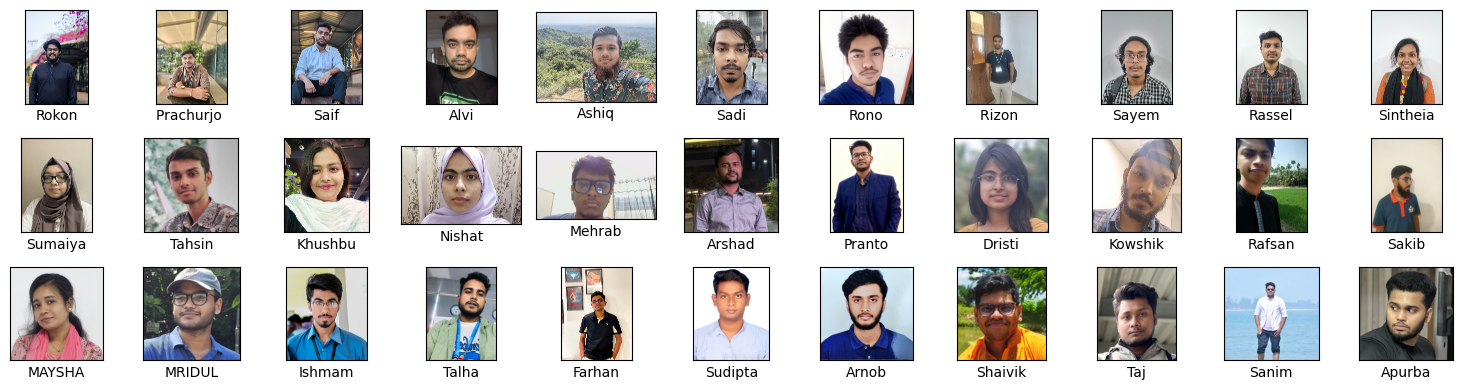

In [5]:
plt.figure(figsize=(15,4))
i=0
for c in categories:
    path = os.path.join(data_dir,c)
    try:
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            plt.subplot(3,11,i+1)
            plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            plt.xlabel(c)
            plt.xticks([])
            plt.yticks([])
            i += 1
            break
    except Exception as e:
        pass
plt.tight_layout()
plt.show()

In [11]:
train_gen = ImageDataGenerator(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=30,
     # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.2,
    # set range for random zoom
    zoom_range=0.3,
    # randomly flip images
    horizontal_flip=True,
    # set function that will be applied on each input
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
train_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)
valid_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 344 images belonging to 56 classes.
Found 72 images belonging to 56 classes.


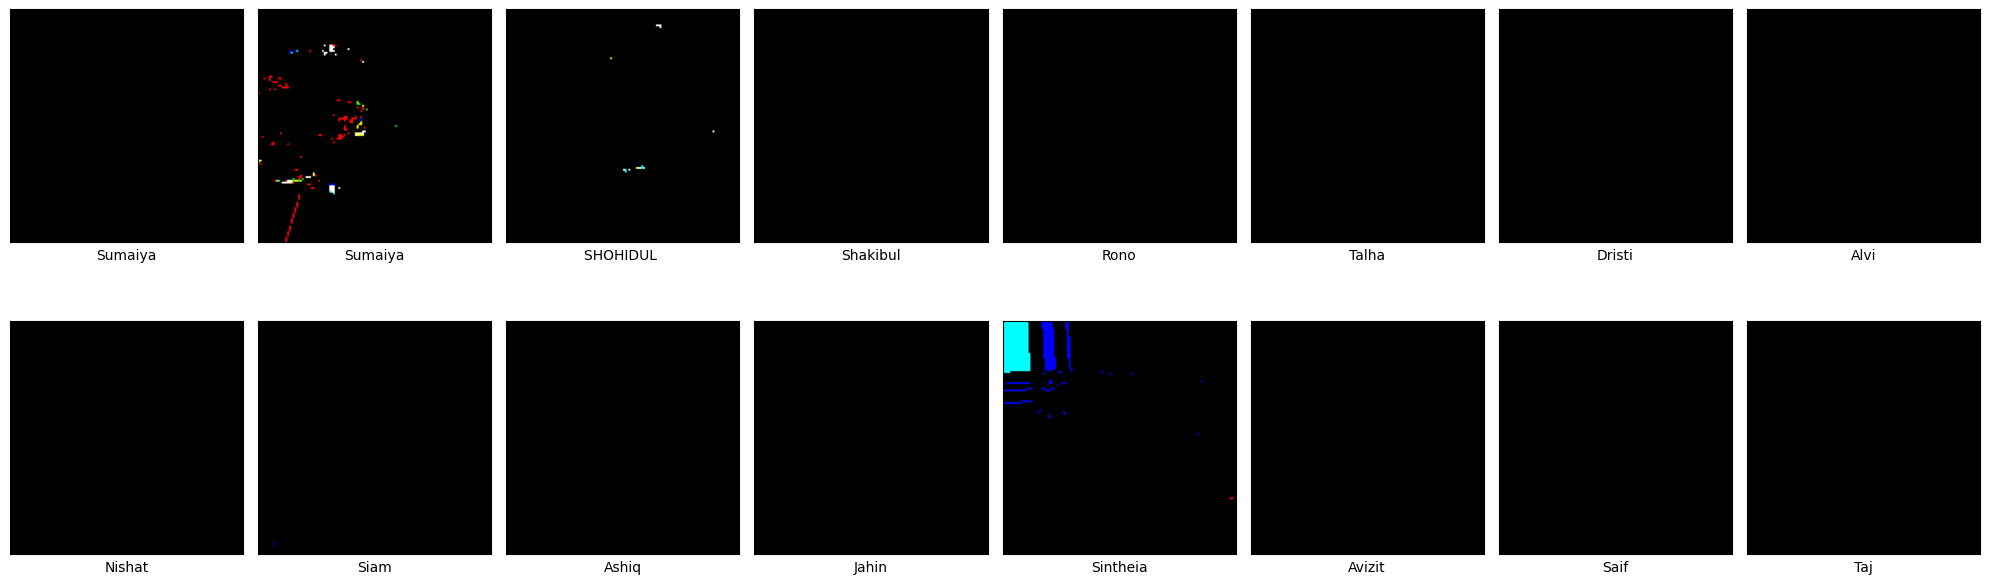

In [7]:
# display 16 items  for a batch
imgs, labels = next(train_batches)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(2,8,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(categories[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [8]:
imput_shape = (IMG_SIZE, IMG_SIZE)+(3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=imput_shape,
    include_top=False,
    weights='imagenet'
)
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base_model(input,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(categories),activation='softmax')(x)
model = tf.keras.Model(input,output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 57)                  │           7,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,085,433 (11.77 MB)

 Trainable params: 3,051,321 (11.64 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
#callbacks = [
   # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
   # ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
#]

In [12]:
h = model.fit(
    train_batches,steps_per_epoch=344//BATCH_SIZE,
    epochs=30,
    validation_data=valid_batches,
    validation_steps=72//BATCH_SIZE,
   # callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 205s 6s/step - accuracy: 0.0259 - loss: 4.1027 - val_accuracy: 0.0156 - val_loss: 4.0103
Epoch 2/30
 1/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.0000e+00 - loss: 3.9626

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 379ms/step - accuracy: 0.0000e+00 - loss: 3.9626 - val_accuracy: 0.0000e+00 - val_loss: 4.1662
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.1269 - loss: 3.7852 - val_accuracy: 0.1406 - val_loss: 3.7926
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2500 - loss: 3.5265 - val_accuracy: 0.1250 - val_loss: 3.8041
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2639 - loss: 3.4632 - val_accuracy: 0.1094 - val_loss: 3.6628
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4375 - loss: 3.1480 - val_accuracy: 0.1250 - val_loss: 3.5270
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3417 - loss: 3.0899 - val_accuracy: 0.2188 - val_loss: 3.3682
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4375 - loss: 2.7616 - val_accuracy: 0.0000e+00 - val_loss: 3.7554
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4426 - loss: 2.5397 - val_accuracy: 0.1562 - val_lo

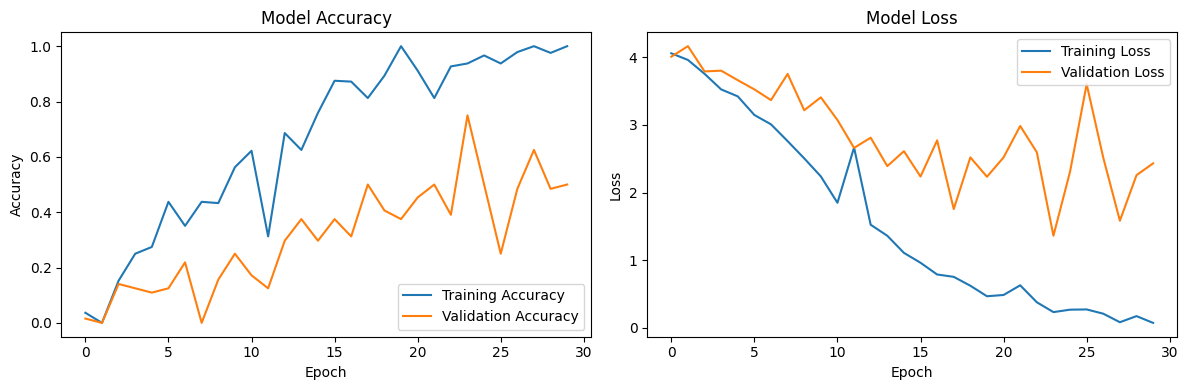

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
model.save('/content/drive/MyDrive/Computer vission/Dataset/Final_My_Attendance.h5')

In [17]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import pandas as pd
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

In [18]:
model = load_model('/content/drive/MyDrive/Computer vission/Dataset/Final_My_Attendance.h5')

In [19]:
Data_Path='/content/drive/MyDrive/Computer vission/Dataset/Attendance_dataset'
classes = os.listdir(Data_Path)
print("class_names :", classes)

class_names : ['Rokon', 'Prachurjo ', 'ASHHAB', 'Saif', 'Alvi', 'Ashiq', 'Sadi', 'Rono', 'Rizon ', 'Sayem', 'Rassel', 'Sintheia', 'Sumaiya', 'Tahsin', 'Khushbu', 'Nishat', 'Mehrab', 'Arshad', 'Pranto', 'Dristi', 'Kowshik', 'Rafsan', 'Sakib', 'MAYSHA', 'MRIDUL', 'Ishmam', 'Talha', 'Farhan', 'Sudipta', 'Arnob', 'Shaivik', 'Taj', 'Sanim', 'Apurba', 'Hasnatur', 'Afif', 'Jahin', 'Hasib', 'Tahsin Kabir', 'Siam', 'SHUVO', 'Zarin', 'Maishara', 'Shakibul', 'SUN', 'GM ABUBAKAR SIDDIQ', 'Ramisa', 'Abir', 'Ridoy', 'SHOHIDUL ', 'Avizit', 'Shatabdi', 'ajmain', 'Shaila', 'ShuvoSaha', 'Nipa Rahman', 'attendance.xlsx']


In [ ]:
'''
# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start video capture from the webcam
cap = cv2.VideoCapture(0)  # '0' means the first connected webcam

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each detected face
    for (x, y, w, h) in faces:
        # Draw a bounding box around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract the face region of interest (ROI)
        face_roi = gray[y:y + h, x:x + w]

        # Resize face image to match the model input shape (128x128) and normalize
        resized_face = cv2.resize(face_roi, (128, 128)) / 255.0

        # Reshape the image to fit the model's expected input
        input_image = np.expand_dims(resized_face, axis=-1)  # Add the channel dimension (grayscale)
        input_image = np.repeat(input_image, 3, axis=-1)  # Convert grayscale to 3 channels
        input_image = np.expand_dims(input_image, axis=0)  # Add the batch dimension

        # Perform prediction using the model
        predictions = model.predict(input_image)
        predicted_class = np.argmax(predictions)
        predicted_class_name = classes[predicted_class]

        # Display the predicted class on the frame
        cv2.putText(frame, f'Class: {predicted_class_name}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the resulting frame with bounding boxes and predictions
    cv2.imshow('Face Detection and Classification', frame)

    # Press 'q' to exit the video stream
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()
'''

"\n# Initialize the Haar Cascade face detection model\nface_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')\n\n# Start video capture from the webcam\ncap = cv2.VideoCapture(0)  # '0' means the first connected webcam\n\nwhile True:\n    # Capture frame-by-frame\n    ret, frame = cap.read()\n\n    if not ret:\n        break\n\n    # Convert the frame to grayscale for face detection\n    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n\n    # Detect faces in the frame\n    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))\n\n    # Process each detected face\n    for (x, y, w, h) in faces:\n        # Draw a bounding box around the face\n        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)\n\n        # Extract the face region of interest (ROI)\n        face_roi = gray[y:y + h, x:x + w]\n\n        # Resize face image to match the model input shape (128x128) and normalize\n        resiz

In [20]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# Helper Function
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):

  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [22]:
import pandas as pd
from datetime import datetime as DT

# Function to create an Excel file for attendance
def create_Excel(filename='/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx', student_names=[]):
    current_date = DT.now().strftime('%Y-%m-%d')
    data = {
        "Name": student_names,
        current_date: [0] * len(student_names)
    }
    df = pd.DataFrame(data)
    try:
        df.to_excel(filename, index=False)
        print(f"Excel file '{filename}' created successfully!")
    except Exception as e:
        print(f"Error occurred while creating the Excel file '{filename}': {e}")

# Function to update attendance in the Excel file
def update_attend(filename, student_name):
    current_date = DT.now().strftime('%Y-%m-%d')

    try:
        df = pd.read_excel(filename)

        if student_name in df['Name'].values:
            index = df.index[df['Name'] == student_name][0]
            attendance = df.at[index, current_date]

            # Check attendance status
            if attendance == 1:
                print(f"{student_name} has already attended.")
            else:
                # Update attendance to 1
                df.at[index, current_date] = 1
                print(f"{student_name}'s attendance marked as 1.")
        else:
            print(f"Student '{student_name}' doesn't exist in the records.")

        df.to_excel(filename, index=False)
    except Exception as e:
        print(f"Error occurred while updating the Excel file '{filename}': {e}")

video_stream()

label_html = 'Capturing...'

# Initialize bounding box to empty
bbox = ''
count = 0

# Loop to process video frames
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract face region from the frame
        face_roi = gray[y:y+h, x:x+w]

        # Resize face image to match model input shape
        resized_face = cv2.resize(face_roi, (128, 128))

        # Normalize face image
        normalized_face = resized_face / 255.0

        # Expand dimensions to represent batch size (1 in this case)
        input_image_batch = np.expand_dims(normalized_face, axis=0)

        # Repeat the single-channel image to create three channels
        input_image_batch = np.repeat(input_image_batch, 3, axis=-1)

        # Reshape for the model input
        input_image_batch = input_image_batch.reshape(-1, 128, 128, 3)

        # Perform prediction using the model
        predictions = model.predict(input_image_batch)
        predicted_class = np.argmax(predictions)
        predicted_class_name = classes[predicted_class]
        print("Predicted class:", predicted_class_name)

        # Update attendance in Excel
        update_attend('/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx', predicted_class_name)

        # Draw bounding box around the face
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Display the predicted class name on the frame
        text = f'Predicted Class Name: {predicted_class_name}'
        cv2.putText(img, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Convert the frame with bounding boxes to bytes
        frame_bytes = cv2.imencode('.jpg', img)[1].tobytes()

        # Update bounding box for the next frame
        # bbox = bbox_to_bytes(frame_bytes)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Pranto
Error occurred while updating the Excel file '/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx': '2024-09-30'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: Rafsan
Error occurred while updating the Excel file '/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx': '2024-09-30'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: Mehrab
Error occurred while updating the Excel file '/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx': '2024-09-30'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: Mehrab
Error occurred while updating the Excel file '/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx': '2024-09-30'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class: Mehrab
Error occurred while updating the Excel file '/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx': '2024-09-30'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted class: Khushbu
Err

In [ ]:
create_Excel('/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx', classes)

Excel file '/content/drive/MyDrive/Computer vission/Dataset/attendance.xlsx' created successfully!
